1. Import necessary libraries

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, make_scorer
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2. Preprocessing data

In [ ]:
# Load data
file_path = '/content/Dataset_Malaga.csv'
df = pd.read_csv(file_path)

# Drop rows with missing targets
df_Complete = df.dropna(subset=['maxspeed', 'lanes', 'surface'])

# Remove 'signals' from maxspeed
df_Complete = df_Complete[df_Complete['maxspeed'] != 'signals']

# Encode targets to categorical codes
df_Complete['maxspeed_cat'] = df_Complete['maxspeed'].astype('category').cat.codes
df_Complete['surface_cat'] = df_Complete['surface'].astype('category').cat.codes
df_Complete['lanes_cat'] = df_Complete['lanes'].astype('category').cat.codes  # categorical lanes if needed

# Encode other categorical features
df_Complete['highway_cat'] = df_Complete['highway'].astype('category').cat.codes
df_Complete['CLC_Merged_Majority_cat'] = df_Complete['CLC_Merged_Majority'].astype('category').cat.codes

# Format sinuosity
df_Complete['sinuosity'] = df_Complete['sinuosity'].apply(lambda x: float(f"{x:.10e}"))

# Drop columns and fill NaN with 0
df_Complete = df_Complete.drop(columns = ['ID', 'osm_id', 'name', 'Geometry_Midpoint', 'Geometry_LineString', 'highway', 'surface', 'maxspeed', 'lanes', 'CLC_Merged_Majority'])
df_Complete = df_Complete.fillna(0)

# Select numeric columns
numeric_cols = df_Complete.select_dtypes(include=['int64', 'float64']).columns

# Apply 95th percentile clipping
for col in numeric_cols:
    upper_limit = df_Complete[col].quantile(0.95)
    lower_limit = df_Complete[col].quantile(0.05)
    df_Complete[col] = df_Complete[col].clip(lower=lower_limit, upper=upper_limit)
    print(f"{col}: clipped to range {lower_limit:.2f} - {upper_limit:.2f}")

sinuosity: clipped to range 1.00 - 1.14
Average_Slope: clipped to range 0.28 - 13.99
GDP: clipped to range 22876.90 - 32619.80
Average_Pop_Density: clipped to range 40.56 - 11723.06


In [ ]:
df_Complete

,sinuosity,Average_Slope,GDP,Average_Pop_Density,maxspeed_cat,surface_cat,lanes_cat,highway_cat,CLC_Merged_Majority_cat
0,1.001917,1.564524,22876.9,203.890198,1,0,1,0,2
1,1.004106,9.695560,32619.8,887.778748,0,0,1,0,0
2,1.002508,1.189768,32619.8,6736.685059,5,0,2,2,1
5,1.024515,4.131490,32619.8,4314.972656,8,0,1,8,0
6,1.040417,6.589955,32619.8,877.694173,8,0,1,8,2
...,...,...,...,...,...,...,...,...,...
16093,1.128903,5.125904,32619.8,6125.523926,4,0,0,6,0
16094,1.136846,4.199532,32619.8,6125.523926,4,0,1,4,0
16095,1.136846,4.199532,32619.8,6125.523926,4,0,1,4,0
16096,1.000051,4.626186,32619.8,6125.523926,4,0,0,4,0


3. Visualizing variables range

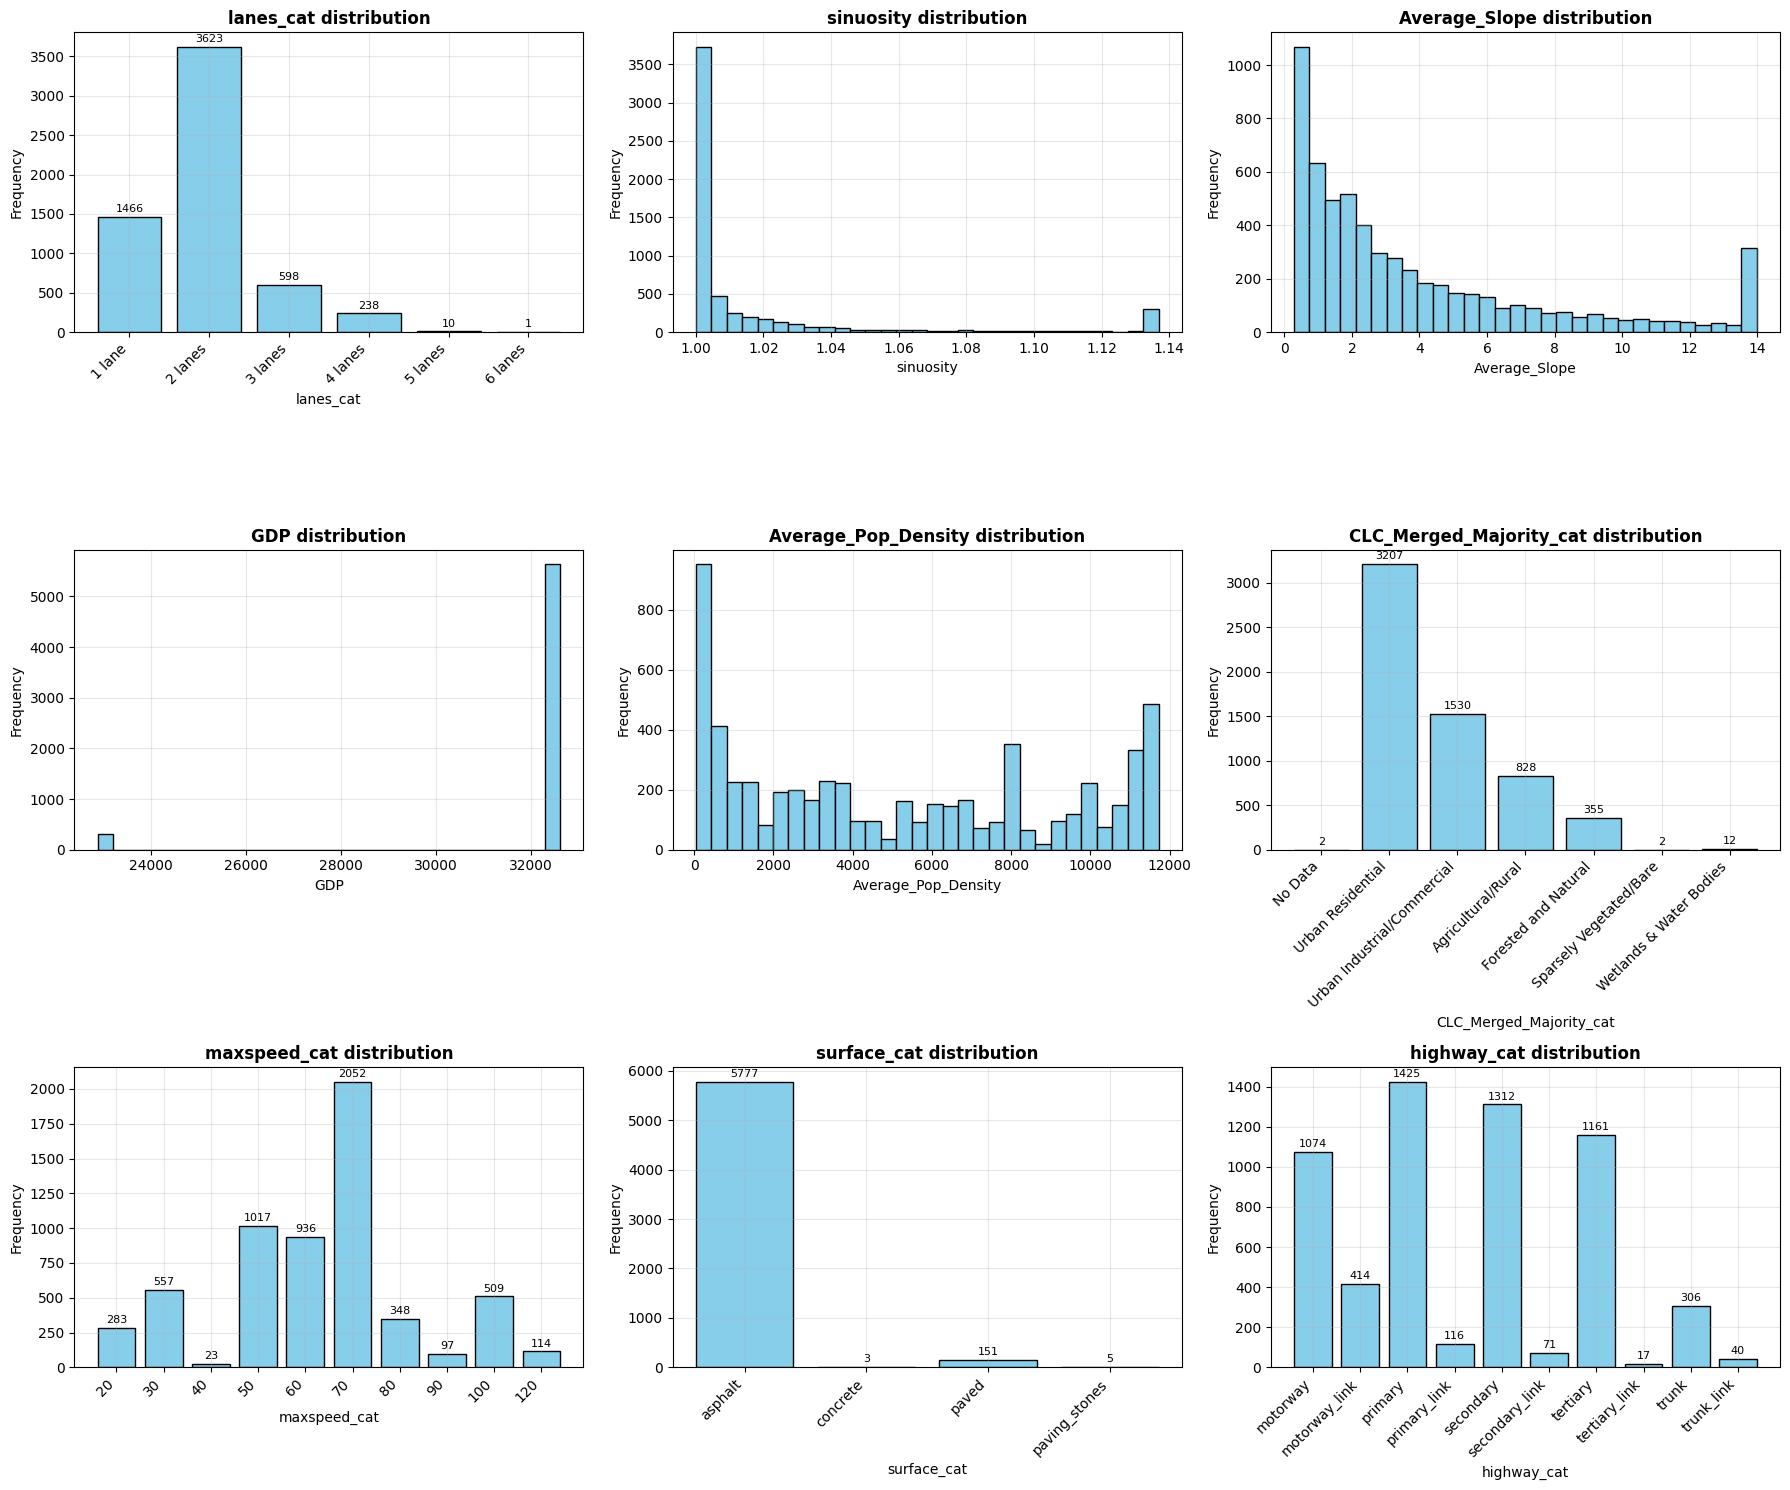

Category Mappings Reference:

surface_cat:
  0: asphalt
  1: concrete
  2: paved
  3: paving_stones

highway_cat:
  0: motorway
  1: motorway_link
  2: primary
  3: primary_link
  4: secondary
  5: secondary_link
  6: tertiary
  7: tertiary_link
  8: trunk
  9: trunk_link

maxspeed_cat:
  0: 20
  1: 30
  2: 40
  3: 50
  4: 60
  5: 70
  6: 80
  7: 90
  8: 100
  9: 120

lanes_cat:
  0: 1 lane
  1: 2 lanes
  2: 3 lanes
  3: 4 lanes
  4: 5 lanes
  5: 6 lanes

CLC_Merged_Majority_cat:
  -1: No Data
  0: Urban Residential
  1: Urban Industrial/Commercial
  2: Agricultural/Rural
  3: Forested and Natural
  4: Sparsely Vegetated/Bare
  5: Wetlands & Water Bodies


In [ ]:
# Category mappings
surface_labels = {0: 'asphalt', 1: 'concrete', 2: 'paved', 3: 'paving_stones'}
highway_labels = {
    0: 'motorway', 1: 'motorway_link', 2: 'primary', 3: 'primary_link',
    4: 'secondary', 5: 'secondary_link', 6: 'tertiary', 7: 'tertiary_link',
    8: 'trunk', 9: 'trunk_link'
}
maxspeed_labels = {0: '20', 1: '30', 2: '40', 3: '50', 4: '60', 5: '70', 6: '80', 7: '90', 8: '100', 9: '120'}
lanes_labels = {0: '1 lane', 1: '2 lanes', 2: '3 lanes', 3: '4 lanes', 4: '5 lanes', 5: '6 lanes'}
clc_labels = {
    -1: 'No Data',
    0: 'Urban Residential',
    1: 'Urban Industrial/Commercial',
    2: 'Agricultural/Rural',
    3: 'Forested and Natural',
    4: 'Sparsely Vegetated/Bare',
    5: 'Wetlands & Water Bodies'
}

# List of all input features
features = [
    'lanes_cat', 'sinuosity', 'Average_Slope',
    'GDP', 'Average_Pop_Density', 'CLC_Merged_Majority_cat',
    'maxspeed_cat', 'surface_cat', 'highway_cat'
]

# Define which features are categorical and their corresponding label mappings
categorical_features = {
    'surface_cat': surface_labels,
    'highway_cat': highway_labels,
    'maxspeed_cat': maxspeed_labels,
    'lanes_cat': lanes_labels,
    'CLC_Merged_Majority_cat': clc_labels
}

# Plot histograms
plt.figure(figsize=(18, 15))
for idx, col in enumerate(features):
    plt.subplot(3, 3, idx + 1)

    if col in categorical_features:
        # For categorical variables, create a bar plot with proper labels
        value_counts = df_Complete[col].value_counts().sort_index()
        categories = value_counts.index
        frequencies = value_counts.values

        # Create bar plot
        bars = plt.bar(range(len(categories)), frequencies, color='skyblue', edgecolor='black')

        # Set custom x-tick labels
        labels = [categorical_features[col].get(cat, f'Cat_{cat}') for cat in categories]
        plt.xticks(range(len(categories)), labels, rotation=45, ha='right')

        # Add value labels on top of bars
        for i, (bar, freq) in enumerate(zip(bars, frequencies)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(frequencies)*0.01,
                    str(freq), ha='center', va='bottom', fontsize=8)
    else:
        # For continuous variables, use histogram
        df_Complete[col].hist(bins=30, color='skyblue', edgecolor='black')

    plt.title(f'{col} distribution', fontsize=12, fontweight='bold')
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.grid(True, alpha=0.3)

    # Adjust layout for better readability
    if col in categorical_features:
        plt.tight_layout()

plt.tight_layout()
plt.show()

# Optional: Print category mappings for reference
print("Category Mappings Reference:")
print("=" * 50)
for feature, mapping in categorical_features.items():
    print(f"\n{feature}:")
    for code, label in mapping.items():
        print(f"  {code}: {label}")

4. Train Random Forest model

In [ ]:
# Define base features
base_features = [
    'sinuosity',
    'Average_Slope',
    'CLC_Merged_Majority_cat',
    'GDP',
    'Average_Pop_Density',
    'highway_cat'
]

def train_rf_for_target(target, features, estimators_list, depths_list):
    print(f"\nTraining Random Forest for predicting '{target}' with parameter grid search\n")
    X = df_Complete[features]
    y = df_Complete[target]

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Scoring metrics including accuracy, weighted precision, recall, f1, and ROC AUC
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='weighted', zero_division=0),
        'recall': make_scorer(recall_score, average='weighted', zero_division=0),
        'f1': make_scorer(f1_score, average='weighted', zero_division=0),
        'roc_auc_ovr': 'roc_auc_ovr_weighted'
    }

    results = []

    for n in estimators_list:
        for d in depths_list:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
            scores = cross_validate(rf, X, y, cv=cv, scoring=scoring)
            result = {
                'n_estimators': n,
                'max_depth': d,
                'mean_accuracy': scores['test_accuracy'].mean(),
                'mean_precision': scores['test_precision'].mean(),
                'mean_recall': scores['test_recall'].mean(),
                'mean_f1': scores['test_f1'].mean(),
                'mean_roc_auc_ovr': scores['test_roc_auc_ovr'].mean()
            }
            results.append(result)

    df_results = pd.DataFrame(results)

    # Sort by mean_f1 descending for best models first
    df_results = df_results.sort_values(by='mean_f1', ascending=False).reset_index(drop=True)

    print(f"Results for target: {target}")
    print(df_results.to_string(index=False, float_format='{:0.4f}'.format))

    return df_results

# Define feature sets per target
features_maxspeed = base_features + ['lanes_cat', 'surface_cat']
features_lanes = base_features + ['maxspeed_cat', 'surface_cat']
features_surface = base_features + ['maxspeed_cat', 'lanes_cat']

# Hyperparameter grids
estimators_list = [100, 150, 200]
depths_list = [10, 13, 16]

# Run training and evaluation for each target
results_maxspeed = train_rf_for_target('maxspeed_cat', features_maxspeed, estimators_list, depths_list)
results_lanes = train_rf_for_target('lanes_cat', features_lanes, estimators_list, depths_list)
results_surface = train_rf_for_target('surface_cat', features_surface, estimators_list, depths_list)

# Optionally combine all results
all_results = pd.concat([results_maxspeed.assign(target='maxspeed_cat'),
                         results_lanes.assign(target='lanes_cat'),
                         results_surface.assign(target='surface_cat')],
                        ignore_index=True)

# Display combined results overview
print("\nAll results combined:")
print(all_results[['target', 'n_estimators', 'max_depth', 'mean_accuracy', 'mean_precision', 'mean_recall', 'mean_f1', 'mean_roc_auc_ovr']]
      .sort_values(by=['target', 'mean_f1'], ascending=[True, False])
      .to_string(index=False, float_format='{:0.4f}'.format))


Training Random Forest for predicting 'maxspeed_cat' with parameter grid search

Results for target: maxspeed_cat
 n_estimators  max_depth  mean_accuracy  mean_precision  mean_recall  mean_f1  mean_roc_auc_ovr
          200         16         0.7545          0.7502       0.7545   0.7487            0.9556
          150         16         0.7505          0.7467       0.7505   0.7451            0.9553
          100         16         0.7493          0.7455       0.7493   0.7438            0.9547
          150         13         0.7476          0.7426       0.7476   0.7406            0.9538
          200         13         0.7461          0.7409       0.7461   0.7389            0.9542
          100         13         0.7429          0.7384       0.7429   0.7357            0.9528
          200         10         0.7200          0.7146       0.7200   0.7089            0.9463
          100         10         0.7195          0.7131       0.7195   0.7084            0.9459
          150        

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py", line 635, in roc_auc_score
    return _multiclass_roc_auc_score(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/

Results for target: lanes_cat
 n_estimators  max_depth  mean_accuracy  mean_precision  mean_recall  mean_f1  mean_roc_auc_ovr
          150         16         0.7524          0.7432       0.7524   0.7350               NaN
          100         16         0.7527          0.7430       0.7527   0.7349               NaN
          200         16         0.7512          0.7423       0.7512   0.7338               NaN
          150         13         0.7470          0.7389       0.7470   0.7233               NaN
          200         13         0.7446          0.7355       0.7446   0.7205               NaN
          100         13         0.7438          0.7340       0.7438   0.7203               NaN
          150         10         0.7268          0.7235       0.7268   0.6918               NaN
          100         10         0.7261          0.7204       0.7261   0.6907               NaN
          200         10         0.7256          0.7195       0.7256   0.6900               NaN

Training 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py", line 635, in roc_auc_score
    return _multiclass_roc_auc_score(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/

Results for target: surface_cat
 n_estimators  max_depth  mean_accuracy  mean_precision  mean_recall  mean_f1  mean_roc_auc_ovr
          150         16         0.9784          0.9749       0.9784   0.9724               NaN
          200         16         0.9786          0.9756       0.9786   0.9723               NaN
          100         16         0.9784          0.9747       0.9784   0.9723               NaN
          150         13         0.9774          0.9747       0.9774   0.9698               NaN
          200         13         0.9773          0.9744       0.9773   0.9695               NaN
          100         13         0.9771          0.9742       0.9771   0.9694               NaN
          100         10         0.9739          0.9681       0.9739   0.9628               NaN
          150         10         0.9739          0.9686       0.9739   0.9628               NaN
          200         10         0.9739          0.9637       0.9739   0.9625               NaN

All res

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py", line 635, in roc_auc_score
    return _multiclass_roc_auc_score(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/

5. Visualize model as confusion matrix and show feature importance

In [ ]:
# Create label mapping
label_dicts = {
    'lanes': lanes_labels,
    'surface': surface_labels,
    'maxspeed': maxspeed_labels
}

In [ ]:
def plot_confusion_matrix(cm, class_labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

def print_confusion_matrix_numpy(cm, class_labels):
    print("Confusion Matrix (rows=actual, columns=predicted):")
    header = "\t" + "\t".join(class_labels)
    print(header)
    for label, row in zip(class_labels, cm):
        print(label + "\t" + "\t".join(map(str, row)))

def kfold_confusion_matrix(X, y, target_name, k=5):
    print(f"\nConfusion Matrix K-Fold Evaluation for '{target_name}'")

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    classes = np.unique(y)
    cm_total = np.zeros((len(classes), len(classes)), dtype=int)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = RandomForestClassifier(n_estimators=200, max_depth=16, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred, labels=classes)
        cm_total += cm

    label_map = label_dicts.get(target_name, {int(c): str(c) for c in classes})
    class_labels = [label_map.get(int(c), str(c)) for c in classes]

    # Print confusion matrix as a copy-friendly table
    print_confusion_matrix_numpy(cm_total, class_labels)

    # Plot confusion matrix heatmap
    plot_confusion_matrix(cm_total, class_labels, f"Confusion Matrix for '{target_name}'")

    # Per-class accuracy
    print("\nPer-Class Accuracy:")
    for i, label in enumerate(class_labels):
        total = np.sum(cm_total[i, :])
        correct = cm_total[i, i]
        acc = correct / total if total > 0 else 0
        print(f"{label}: {acc:.4f}")


Confusion Matrix K-Fold Evaluation for 'maxspeed'
Confusion Matrix (rows=actual, columns=predicted):
	20	30	40	50	60	70	80	90	100	120
20	165	79	0	0	4	2	8	4	21	0
30	49	473	0	0	7	1	3	3	21	0
40	0	0	2	7	7	3	1	0	3	0
50	0	0	0	804	61	146	2	2	0	2
60	3	7	1	103	568	181	37	7	22	7
70	1	0	0	103	83	1825	18	2	13	7
80	8	5	0	6	44	39	192	16	25	13
90	6	2	0	1	14	7	25	37	3	2
100	16	62	0	2	27	29	21	2	340	10
120	0	0	0	3	9	12	14	0	3	73


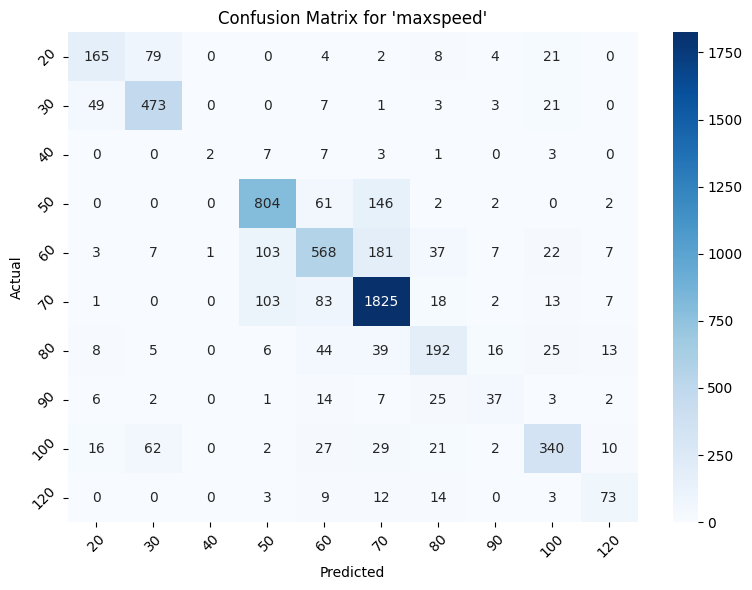


Per-Class Accuracy:
20: 0.5830
30: 0.8492
40: 0.0870
50: 0.7906
60: 0.6068
70: 0.8894
80: 0.5517
90: 0.3814
100: 0.6680
120: 0.6404

Confusion Matrix K-Fold Evaluation for 'lanes'
Confusion Matrix (rows=actual, columns=predicted):
	1 lane	2 lanes	3 lanes	4 lanes	5 lanes	6 lanes
1 lane	1007	454	4	1	0	0
2 lanes	345	3201	62	14	1	0
3 lanes	16	371	195	15	1	0
4 lanes	6	150	26	56	0	0
5 lanes	0	2	7	1	0	0
6 lanes	0	0	1	0	0	0


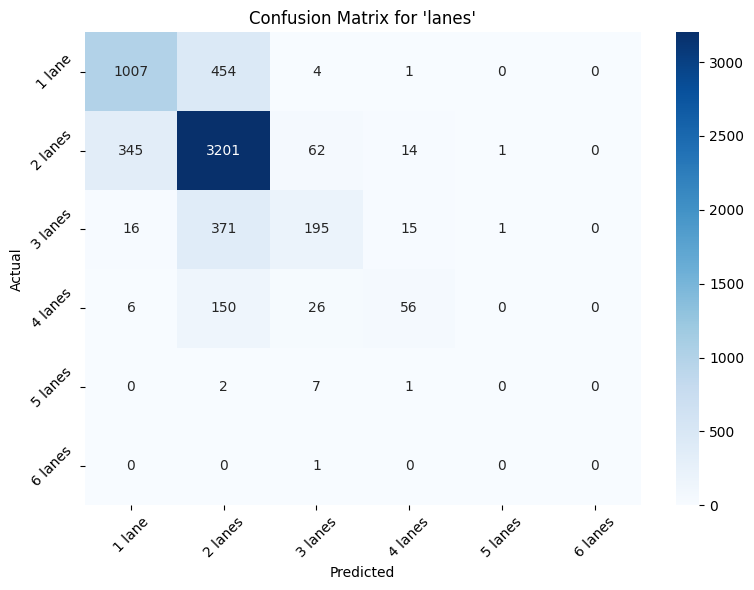


Per-Class Accuracy:
1 lane: 0.6869
2 lanes: 0.8835
3 lanes: 0.3261
4 lanes: 0.2353
5 lanes: 0.0000
6 lanes: 0.0000

Confusion Matrix K-Fold Evaluation for 'surface'
Confusion Matrix (rows=actual, columns=predicted):
	asphalt	concrete	paved	paving_stones
asphalt	5772	0	5	0
concrete	3	0	0	0
paved	114	0	37	0
paving_stones	5	0	0	0


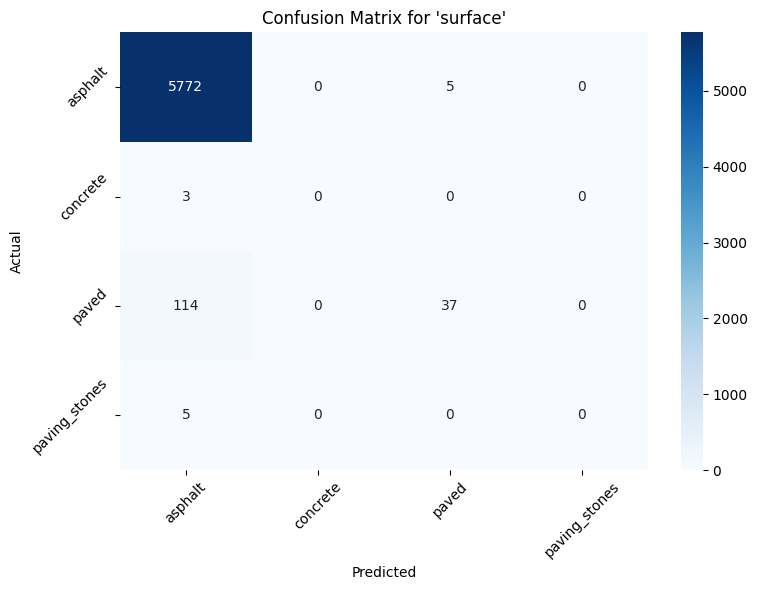


Per-Class Accuracy:
asphalt: 0.9991
concrete: 0.0000
paved: 0.2450
paving_stones: 0.0000


In [ ]:
# Confusion Matrices
kfold_confusion_matrix(df_Complete[features_maxspeed], df_Complete['maxspeed_cat'], 'maxspeed')
kfold_confusion_matrix(df_Complete[features_lanes], df_Complete['lanes_cat'], 'lanes')
kfold_confusion_matrix(df_Complete[features_surface], df_Complete['surface_cat'], 'surface')

In [ ]:
def plot_feature_importances(X, y, target_name, n_estimators=200, max_depth=16):
    print(f"\nFeature Importances for '{target_name}'")
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X, y)

    sorted_idx = model.feature_importances_.argsort()

    plt.figure(figsize=(8, 6))
    plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importances for "{target_name}"')
    plt.tight_layout()
    plt.grid(True, alpha=0.7)
    plt.show()

    # Also return a sorted DataFrame of feature importances
    importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return importances_df


Feature Importances for 'maxspeed_cat'


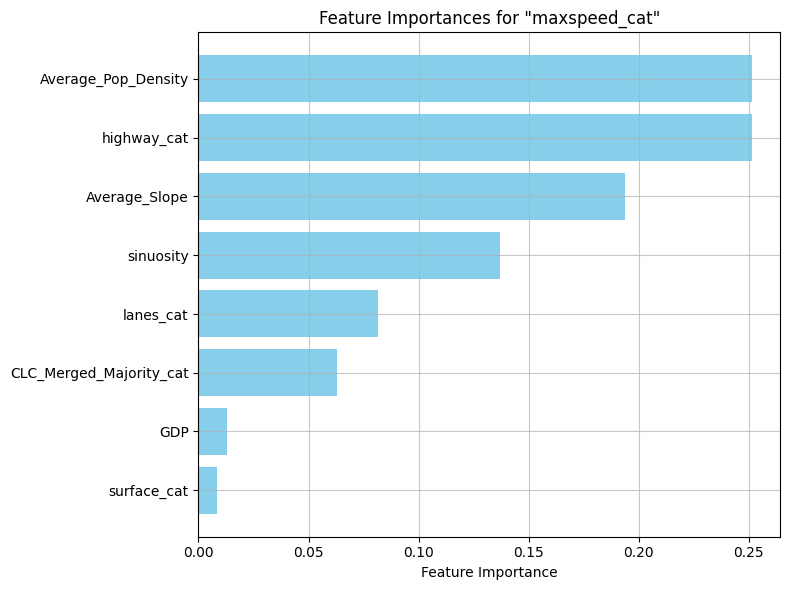


Feature Importances for 'lanes_cat'


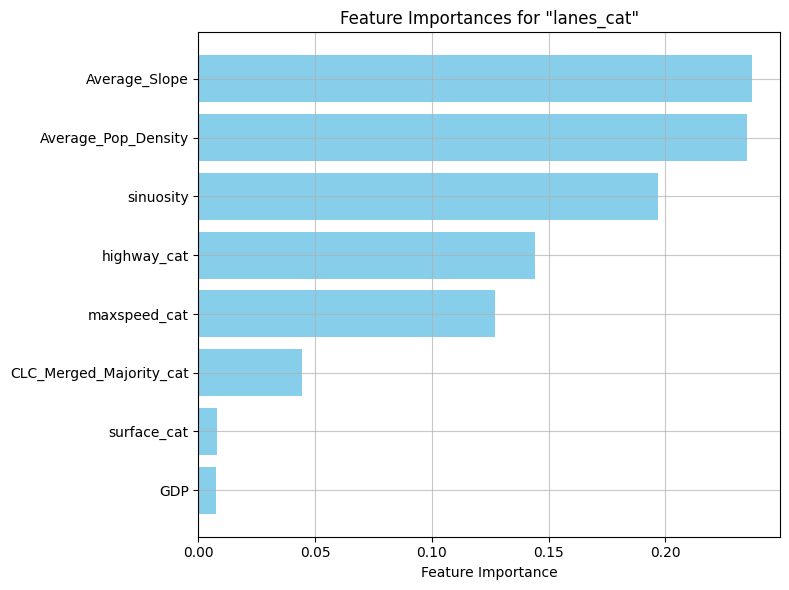


Feature Importances for 'surface_cat'


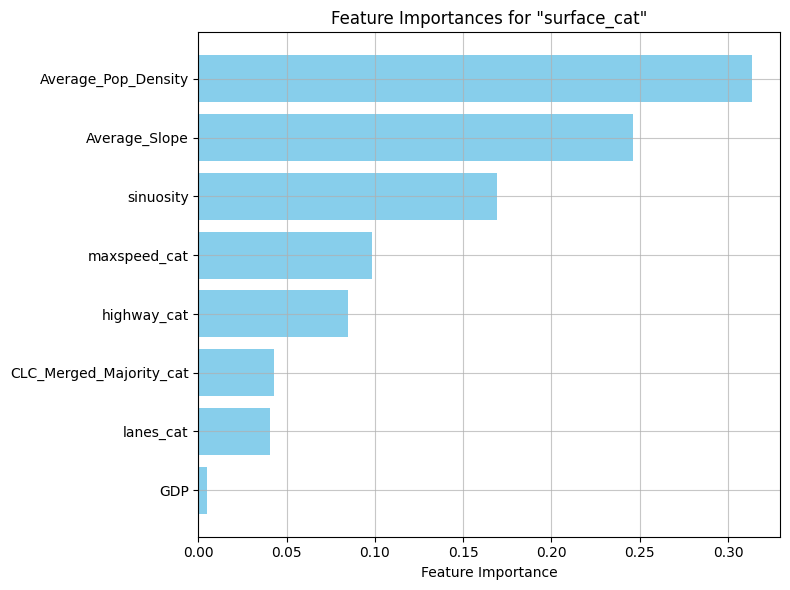

In [ ]:
# Feature sets (you already defined these)
X_maxspeed = df_Complete[features_maxspeed]
y_maxspeed = df_Complete['maxspeed_cat']

X_lanes = df_Complete[features_lanes]
y_lanes = df_Complete['lanes_cat']

X_surface = df_Complete[features_surface]
y_surface = df_Complete['surface_cat']

# Run and get importance DataFrames
importances_maxspeed = plot_feature_importances(X_maxspeed, y_maxspeed, 'maxspeed_cat')
importances_lanes = plot_feature_importances(X_lanes, y_lanes, 'lanes_cat')
importances_surface = plot_feature_importances(X_surface, y_surface, 'surface_cat')
